# **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input, decode_predictions, ResNet50
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import seaborn as sns

2024-04-10 19:08:05.704550: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 19:08:05.704655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 19:08:06.005712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Getting the Data**

In [2]:
pwd

'/kaggle/working'

In [3]:
my_data_dir='/kaggle/working/path/to/your'

# **Train Test Split**

In [4]:
import os
import shutil
import random

# Veri setinin bulunduğu dizin
data_dir = "/kaggle/input/flowers-recognition/flowers"

# Train ve test dizinlerini oluştur
train_dir = "path/to/your/train_data"
test_dir = "path/to/your/test_data"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Veri setindeki sınıflar
classes = os.listdir(data_dir)

# Train ve test oranı
train_ratio = 0.80

# Her sınıf için veri setini train ve test olarak ayır
for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    images = os.listdir(class_dir)
    random.shuffle(images)
    train_size = int(len(images) * train_ratio)
    train_images = images[:train_size]
    test_images = images[train_size:]

    # Train ve test görüntülerini kopyala
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_dir, cls, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_dir, cls, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Train-test split completed successfully.")


Train-test split completed successfully.


In [5]:
os.listdir(my_data_dir)

['test_data', 'train_data']

In [6]:
train_path = my_data_dir+'/train_data'
test_path = my_data_dir+'/test_data'

In [7]:
os.listdir(train_path)

['tulip', 'daisy', 'sunflower', 'dandelion', 'rose']

In [8]:
len(os.listdir(train_path+'/rose'))

627

In [9]:
len(os.listdir(train_path+'/tulip'))

787

In [10]:
os.listdir(train_path+'/rose')[:10]

['3422228549_f147d6e642.jpg',
 '18302780950_9469703544_n.jpg',
 '4495885281_fe2a3b671d.jpg',
 '18492296751_0bf021da9b_n.jpg',
 '10503217854_e66a804309.jpg',
 '8742493689_fb852f0228_n.jpg',
 '14943194730_f48b4d4547_n.jpg',
 '19271410704_932d1f2c97_n.jpg',
 '410425647_4586667858.jpg',
 '14747962886_2bff6bb323_m.jpg']

In [11]:
os.listdir(train_path+'/tulip')[:10]

['9976515506_d496c5e72c.jpg',
 '8733586143_3139db6e9e_n.jpg',
 '14266093711_66d18a1e44_n.jpg',
 '2272006181_785f1be94f_n.jpg',
 '14055601247_2e647ba9b0_n.jpg',
 '14097111174_87a2e7e0c7_n.jpg',
 '3510799169_0ed6ae9669_n.jpg',
 '12883412424_cb5086b43f_n.jpg',
 '7166567320_0a2beb6d42.jpg',
 '4945315538_97bdd873c4.jpg']

In [12]:
path1=train_path+'/rose'+'/5570018782_c56bee942f.jpg'
path2=train_path+'/tulip'+'/16680998737_6f6225fe36.jpg'

In [13]:
rose_img=imread(path1)
tulip_img=imread(path2)

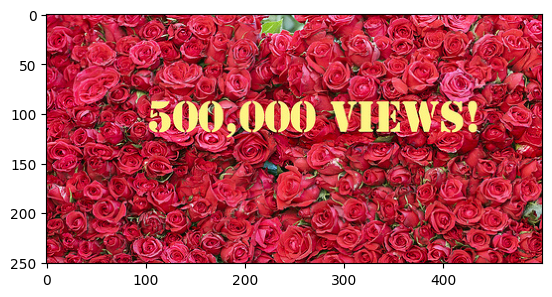

In [14]:
plt.imshow(rose_img);

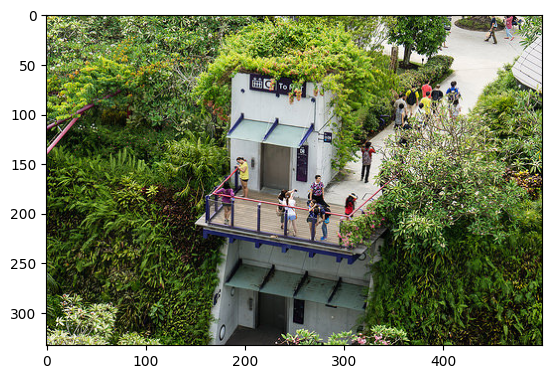

In [15]:
plt.imshow(tulip_img);

# **Data Augmentation**

In [16]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.3,
    rescale = 1/255
)

In [17]:
batch_size = 32
img_height = 256
img_width = 256

In [18]:
classes = ['daisy', 'rose', 'tulip', 'sunflower', 'dandelion']

In [19]:
training_data = image_gen.flow_from_directory(
    train_dir,
    subset = "training",
    class_mode="categorical",
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False
)

validation_data = image_gen.flow_from_directory(
    train_dir,
    subset = "validation",
    class_mode="categorical",
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False
)

Found 2418 images belonging to 5 classes.
Found 1034 images belonging to 5 classes.


In [20]:
image_shape = (256,256,3)

# **CNN Model**

In [21]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
          
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 127, 127, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 594,501 (2.27 MB)

 Trainable params: 593,477 (2.26 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [23]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [24]:
results = model.fit(training_data,epochs=50,
                    validation_data=validation_data,
                    callbacks=[early_stop])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/76 ━━━━━━━━━━━━━━━━━━━━ 38:19 31s/step - accuracy: 0.2188 - loss: 2.1856

I0000 00:00:1712776170.421536      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712776170.443427      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/76 ━━━━━━━━━━━━━━━━━━━━ 7s 734ms/step - accuracy: 0.1970 - loss: 1.7949

W0000 00:00:1712776218.194013      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.1991 - loss: 1.7803

W0000 00:00:1712776221.697341      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 101s 936ms/step - accuracy: 0.1993 - loss: 1.7790 - val_accuracy: 0.2282 - val_loss: 1.6091
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 700ms/step - accuracy: 0.2152 - loss: 1.6195 - val_accuracy: 0.2437 - val_loss: 1.6041
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 701ms/step - accuracy: 0.2469 - loss: 1.6097 - val_accuracy: 0.2437 - val_loss: 1.6096
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 700ms/step - accuracy: 0.2844 - loss: 1.5934 - val_accuracy: 0.2195 - val_loss: 1.5993
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 696ms/step - accuracy: 0.2249 - loss: 1.6135 - val_accuracy: 0.2476 - val_loss: 1.5872
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 700ms/step - accuracy: 0.2679 - loss: 1.5937 - val_accuracy: 0.3269 - val_loss: 1.5774
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 705ms/step - accuracy: 0.2460 - loss: 1.5937 - val_accuracy: 0.2805 - val_loss: 1.5837
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 707ms/step - accuracy: 0.2690 - loss: 1.5976 - val_accuracy: 0.31

In [25]:
summary = pd.DataFrame(model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.214227,1.680007,0.228240,1.609112
1,0.222498,1.613225,0.243714,1.604070
2,0.239454,1.608672,0.243714,1.609600
3,0.248553,1.608649,0.219536,1.599265
4,0.253102,1.604716,0.247582,1.587180
5,0.244003,1.604295,0.326886,1.577374
6,0.229529,1.604259,0.280464,1.583703
7,0.247725,1.603546,0.311412,1.567245
8,0.258478,1.600843,0.241779,1.577366
9,0.254342,1.600778,0.301741,1.561494


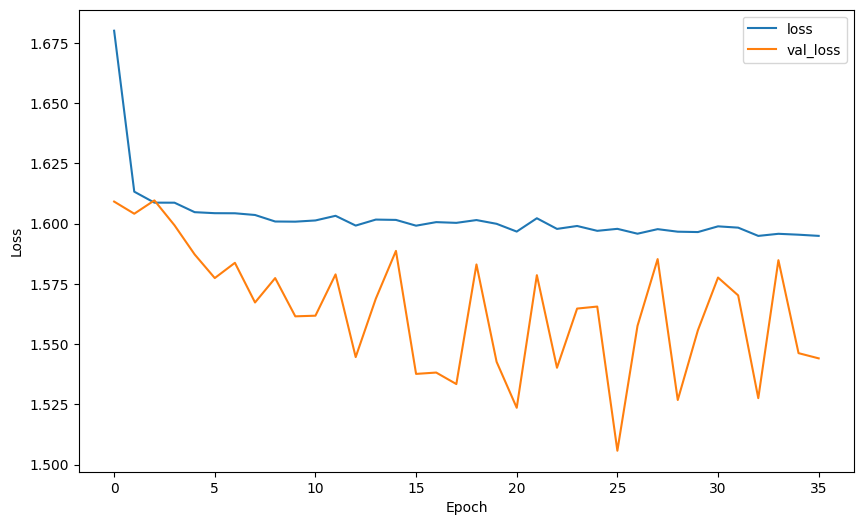

In [26]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

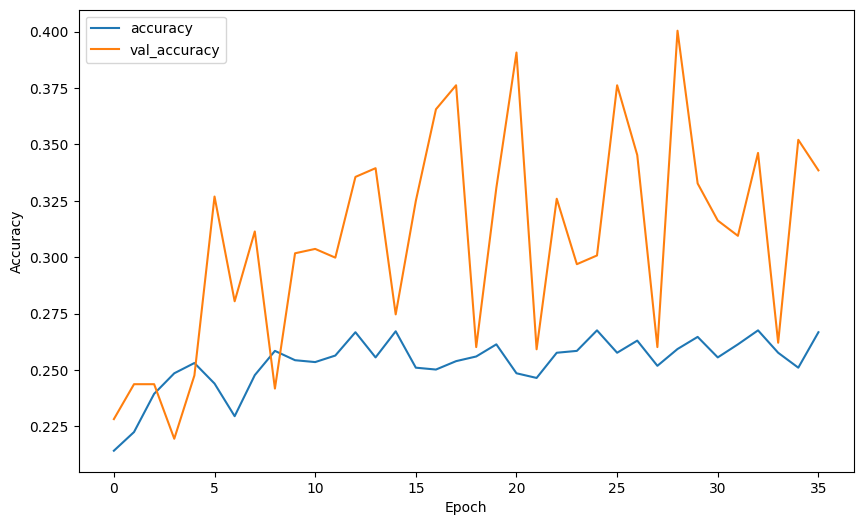

In [27]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [28]:
model.evaluate(training_data)

76/76 ━━━━━━━━━━━━━━━━━━━━ 39s 515ms/step - accuracy: 0.2969 - loss: 1.5972


W0000 00:00:1712778286.658334      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[1.539765477180481, 0.3316790759563446]

In [29]:
model.evaluate(validation_data)

33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 501ms/step - accuracy: 0.3074 - loss: 1.5935


[1.5408995151519775, 0.3297872245311737]

In [30]:
pred_probabilities = model.predict(validation_data)
pred_probabilities

 1/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step

W0000 00:00:1712778306.603658      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 505ms/step


array([[0.15288842, 0.2761929 , 0.16892226, 0.15992361, 0.24207282],
       [0.14938298, 0.27427563, 0.17571694, 0.13941124, 0.26121324],
       [0.18922302, 0.22085877, 0.17180315, 0.14124243, 0.27687258],
       ...,
       [0.22254543, 0.16537468, 0.07290862, 0.32751915, 0.21165216],
       [0.15107046, 0.2765902 , 0.1381264 , 0.19893582, 0.23527703],
       [0.15692605, 0.2596083 , 0.17939758, 0.16119072, 0.24287732]],
      dtype=float32)

In [31]:
validation_data.classes[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [32]:
predictions = pred_probabilities > 0.5

In [33]:
#print(classification_report(validation_data.classes,predictions))

# **ConvNeXtTiny**

In [34]:
convex_model = Sequential()

pretrained_model= tf.keras.applications.ConvNeXtTiny(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

convex_model.add(pretrained_model)
convex_model.add(Flatten())
convex_model.add(Dense(512, activation='relu'))
convex_model.add(Dense(5, activation='softmax'))
convex_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

convex_model.summary()

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_tiny (Functional)      │ ?                      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,820,128 (106.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 27,820,128 (106.13 MB)

In [35]:
results = convex_model.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks=[early_stop])

Epoch 1/25
 1/76 ━━━━━━━━━━━━━━━━━━━━ 28:14 23s/step - accuracy: 0.0000e+00 - loss: 2.0164

W0000 00:00:1712778351.244752      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712778351.245237      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712778351.245692      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712778351.249198      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/76 ━━━━━━━━━━━━━━━━━━━━ 1:07 1s/step - accuracy: 0.1654 - loss: 2.4687  

W0000 00:00:1712778364.269129      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712778364.269470      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712778364.270005      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712778364.271033      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712778364.271445      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712778364.271910      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712778364.272328      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712778364.272690      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.2652 - loss: 2.1142

W0000 00:00:1712778398.786266      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712778398.786626      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712778398.787062      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712778398.790574      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 91s 909ms/step - accuracy: 0.2658 - loss: 2.1115 - val_accuracy: 0.3569 - val_loss: 1.8841
Epoch 2/25


W0000 00:00:1712778419.507723      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712778419.508078      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712778419.508510      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712778419.511395      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712778419.511752      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712778419.512178      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 700ms/step - accuracy: 0.3267 - loss: 1.6895 - val_accuracy: 0.4130 - val_loss: 1.5339
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 708ms/step - accuracy: 0.4721 - loss: 1.4463 - val_accuracy: 0.5609 - val_loss: 1.0773
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 696ms/step - accuracy: 0.4533 - loss: 1.2867 - val_accuracy: 0.6103 - val_loss: 1.0440
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 707ms/step - accuracy: 0.5384 - loss: 1.0978 - val_accuracy: 0.4439 - val_loss: 1.3499
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 707ms/step - accuracy: 0.5418 - loss: 1.2316 - val_accuracy: 0.5522 - val_loss: 1.2594
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 704ms/step - accuracy: 0.5829 - loss: 1.1090 - val_accuracy: 0.6402 - val_loss: 0.9208
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 704ms/step - accuracy: 0.5632 - loss: 1.0604 - val_accuracy: 0.6170 - val_loss: 1.0123
Epoch 9/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 82s 705ms/step - accuracy: 0.6309 - loss: 0.9640 - val_accuracy: 0.647

In [36]:
summary = pd.DataFrame(convex_model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.310587,1.906200,0.356867,1.884077
1,0.391232,1.487287,0.412959,1.533901
2,0.508685,1.370149,0.560928,1.077319
3,0.485939,1.288022,0.610251,1.043979
4,0.557072,1.107783,0.443907,1.349906
5,0.571547,1.136124,0.552224,1.259439
6,0.564103,1.118265,0.640232,0.920824
7,0.593879,1.043132,0.617021,1.012295
8,0.627378,0.976109,0.647002,0.943051
9,0.571547,1.073658,0.647969,0.950487


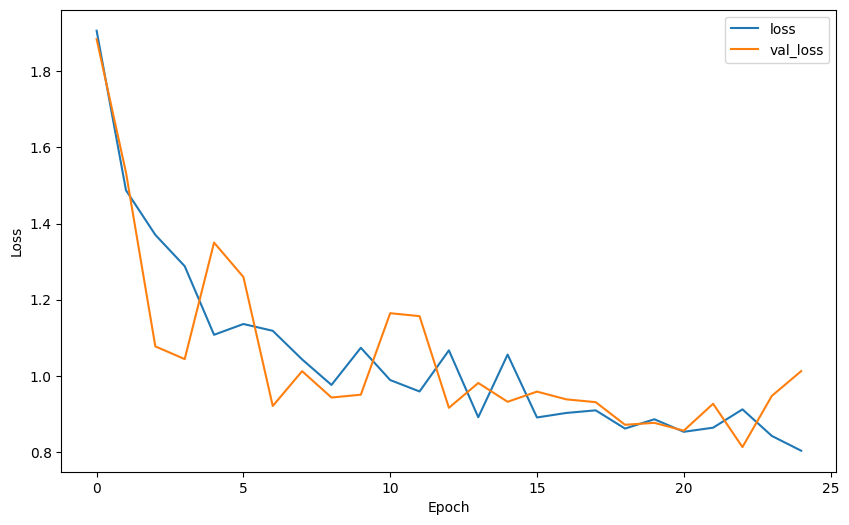

In [37]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

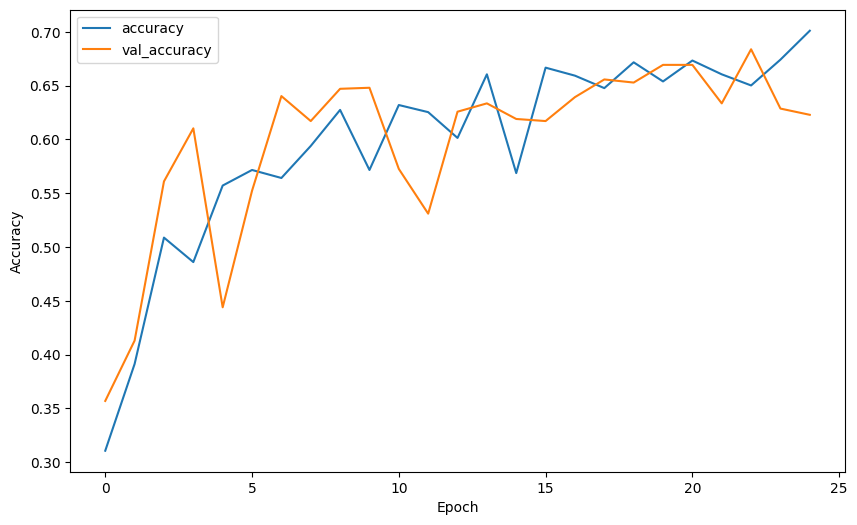

In [38]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [39]:
convex_model.evaluate(training_data)
convex_model.evaluate(validation_data)

76/76 ━━━━━━━━━━━━━━━━━━━━ 42s 545ms/step - accuracy: 0.7466 - loss: 0.6363


W0000 00:00:1712779860.953522      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712779860.953973      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712779860.954455      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712779860.955427      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712779860.955810      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712779860.956170      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712779860.956551      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712779860.956911      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 506ms/step - accuracy: 0.7323 - loss: 0.6878


[1.0000768899917603, 0.6353965401649475]

In [40]:
pred_probabilities = convex_model.predict(validation_data)
pred_probabilities

 2/33 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step

W0000 00:00:1712779884.469955      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712779884.470498      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712779884.471036      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712779884.474606      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 605ms/step


W0000 00:00:1712779903.821804      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712779903.822135      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712779903.822566      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712779903.825515      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712779903.825856      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712779903.826261      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([[0.10621147, 0.82125396, 0.02980121, 0.03038985, 0.01234356],
       [0.7844272 , 0.14557192, 0.02384246, 0.03173666, 0.01442162],
       [0.69965094, 0.19537672, 0.00800027, 0.09347568, 0.00349644],
       ...,
       [0.08465239, 0.14924653, 0.54990107, 0.0129624 , 0.20323758],
       [0.00127388, 0.00348144, 0.05565272, 0.01304658, 0.9265454 ],
       [0.20458993, 0.15773852, 0.5883543 , 0.0171156 , 0.03220166]],
      dtype=float32)

In [41]:
validation_data.classes[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [42]:
predictions = pred_probabilities > 0.5

In [43]:
validation_data.classes

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [44]:
#print(classification_report(validation_data.classes,predictions))

# **Xception Model**

In [45]:
xception_model = Sequential()

pretrained_model= tf.keras.applications.Xception(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

xception_model.add(pretrained_model)
xception_model.add(Flatten())
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(5, activation='softmax'))
xception_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

xception_model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [46]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [47]:
results = xception_model.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks=[early_stop])

Epoch 1/25
 1/76 ━━━━━━━━━━━━━━━━━━━━ 34:42 28s/step - accuracy: 0.0000e+00 - loss: 1.9354

W0000 00:00:1712779941.439227      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/76 ━━━━━━━━━━━━━━━━━━━━ 42s 905ms/step - accuracy: 0.1972 - loss: 3.0476

W0000 00:00:1712779966.692034      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.2940 - loss: 2.3982

W0000 00:00:1712779991.908522      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 101s 976ms/step - accuracy: 0.2959 - loss: 2.3885 - val_accuracy: 0.6741 - val_loss: 0.9489
Epoch 2/25


W0000 00:00:1712780014.737298      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 707ms/step - accuracy: 0.6836 - loss: 0.8473 - val_accuracy: 0.7108 - val_loss: 0.7324
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 702ms/step - accuracy: 0.7863 - loss: 0.5674 - val_accuracy: 0.8124 - val_loss: 0.5069
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 703ms/step - accuracy: 0.7970 - loss: 0.5429 - val_accuracy: 0.7727 - val_loss: 0.5467
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 697ms/step - accuracy: 0.8130 - loss: 0.4947 - val_accuracy: 0.8056 - val_loss: 0.5406
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 702ms/step - accuracy: 0.8386 - loss: 0.4406 - val_accuracy: 0.7969 - val_loss: 0.5284
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 701ms/step - accuracy: 0.8630 - loss: 0.3727 - val_accuracy: 0.8288 - val_loss: 0.5083
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 699ms/step - accuracy: 0.8480 - loss: 0.4080 - val_accuracy: 0.8433 - val_loss: 0.4305
Epoch 9/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 698ms/step - accuracy: 0.9087 - loss: 0.2848 - val_accuracy: 0.807

In [48]:
summary = pd.DataFrame(xception_model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.436311,1.653447,0.674081,0.948867
1,0.711332,0.774172,0.710832,0.732424
2,0.796940,0.553722,0.812379,0.506929
3,0.772539,0.594979,0.772727,0.546713
4,0.801902,0.521122,0.805609,0.540608
5,0.851117,0.411439,0.796905,0.528379
6,0.851117,0.395882,0.828820,0.508321
7,0.855252,0.380114,0.843327,0.430519
8,0.877585,0.350822,0.807544,0.567106
9,0.867246,0.364492,0.829787,0.486651


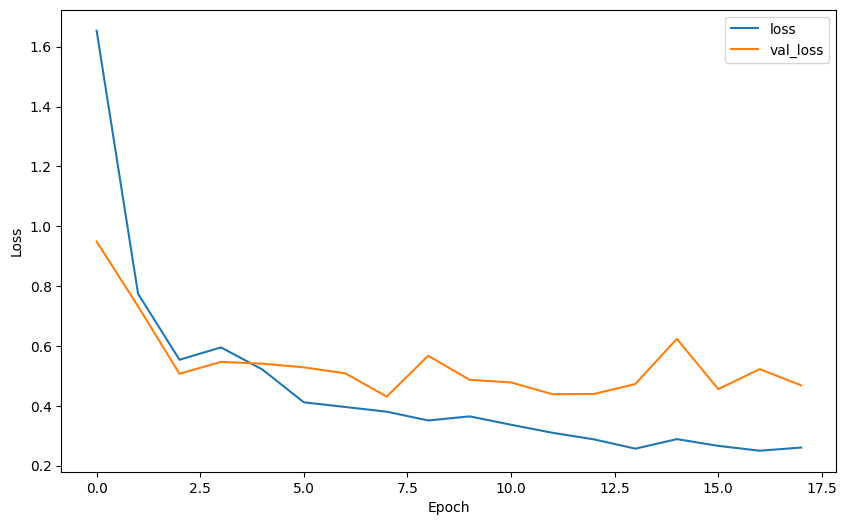

In [49]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

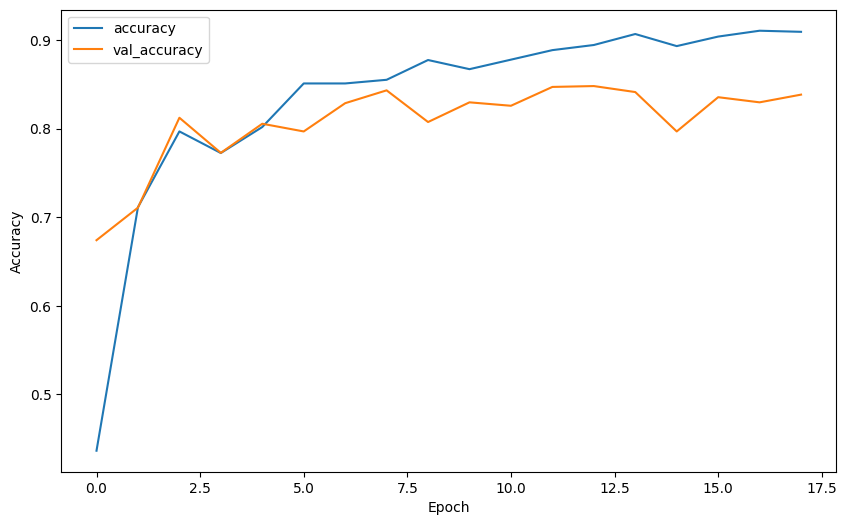

In [50]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [51]:
xception_model.evaluate(training_data)

76/76 ━━━━━━━━━━━━━━━━━━━━ 41s 531ms/step - accuracy: 0.9324 - loss: 0.1913


W0000 00:00:1712781054.331810      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.21543550491333008, 0.9292804002761841]

In [52]:
xception_model.evaluate(validation_data)

33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 503ms/step - accuracy: 0.8814 - loss: 0.3366


[0.4390682280063629, 0.8433268666267395]

In [53]:
pred_probabilities = xception_model.predict(validation_data)
pred_probabilities

 2/33 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step

W0000 00:00:1712781078.016488      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 574ms/step


W0000 00:00:1712781096.371117      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([[9.99054492e-01, 5.93803998e-05, 1.47456740e-04, 4.86517063e-04,
        2.52185419e-04],
       [9.98219192e-01, 7.38469098e-05, 3.05124588e-04, 5.07312827e-04,
        8.94504774e-04],
       [9.69129443e-01, 9.85629484e-03, 1.70161715e-03, 4.94417909e-04,
        1.88181736e-02],
       ...,
       [1.15354471e-02, 4.81013383e-04, 7.20888376e-03, 1.13041715e-04,
        9.80661631e-01],
       [9.56309032e-06, 3.61440243e-06, 7.89850135e-04, 1.26801069e-05,
        9.99184310e-01],
       [2.76007951e-04, 1.63993554e-05, 9.91909444e-01, 8.26504431e-04,
        6.97165309e-03]], dtype=float32)

In [54]:
validation_data.classes[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [55]:
predictions = pred_probabilities > 0.5

In [56]:
from sklearn.metrics import classification_report
#print(classification_report(validation_data.classes,predictions))

# **VCG16 Model**

In [57]:
vcg16_model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

vcg16_model.add(pretrained_model)
vcg16_model.add(Flatten())
vcg16_model.add(Dense(512, activation='relu'))
vcg16_model.add(Dense(5, activation='softmax'))
vcg16_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

vcg16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [58]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [59]:
results = vcg16_model.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks=[early_stop])

Epoch 1/25
 1/76 ━━━━━━━━━━━━━━━━━━━━ 59:43 48s/step - accuracy: 0.0000e+00 - loss: 1.9331

W0000 00:00:1712781153.827028      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.2621 - loss: 1.8072

W0000 00:00:1712781217.148797      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.2631 - loss: 1.8049 - val_accuracy: 0.3520 - val_loss: 1.4321
Epoch 2/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 708ms/step - accuracy: 0.4018 - loss: 1.3820 - val_accuracy: 0.5000 - val_loss: 1.4218
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 703ms/step - accuracy: 0.4863 - loss: 1.3345 - val_accuracy: 0.5870 - val_loss: 1.1282
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 707ms/step - accuracy: 0.6299 - loss: 1.0184 - val_accuracy: 0.5977 - val_loss: 1.0556
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 700ms/step - accuracy: 0.6152 - loss: 1.0200 - val_accuracy: 0.6654 - val_loss: 0.8962
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 708ms/step - accuracy: 0.6409 - loss: 0.9563 - val_accuracy: 0.6567 - val_loss: 0.9435
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 700ms/step - accuracy: 0.7005 - loss: 0.8643 - val_accuracy: 0.6557 - val_loss: 0.8702
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 57s 698ms/step - accuracy: 0.6934 - loss: 0.8274 - val_accuracy: 0.6383 

In [60]:
summary = pd.DataFrame(vcg16_model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.339950,1.628016,0.352031,1.432112
1,0.475186,1.288708,0.500000,1.421784
2,0.541357,1.178262,0.587041,1.128232
3,0.615385,0.994688,0.597679,1.055632
4,0.613317,1.013817,0.665377,0.896154
5,0.620761,0.997724,0.656673,0.943493
6,0.702647,0.839591,0.655706,0.870217
7,0.681555,0.857184,0.638298,0.945700
8,0.686104,0.821874,0.634429,0.968865
9,0.700579,0.794630,0.667311,0.856978


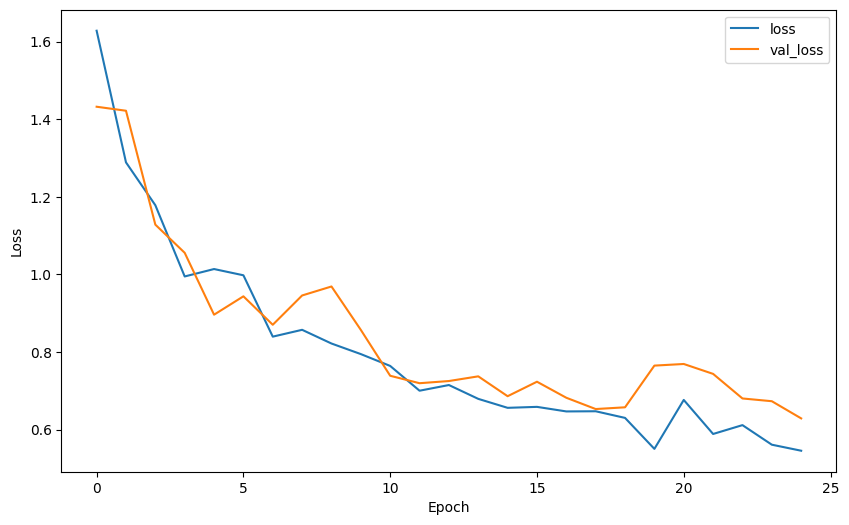

In [61]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

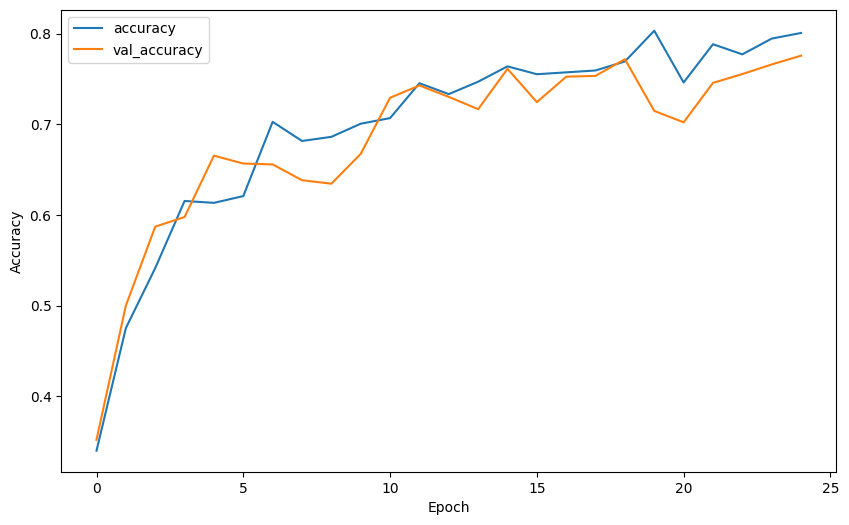

In [62]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [63]:
vcg16_model.evaluate(training_data)
vcg16_model.evaluate(validation_data)

76/76 ━━━━━━━━━━━━━━━━━━━━ 40s 524ms/step - accuracy: 0.8068 - loss: 0.5409
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 509ms/step - accuracy: 0.7631 - loss: 0.5977


[0.620274543762207, 0.7717601656913757]

In [64]:
pred_probabilities = vcg16_model.predict(validation_data)
pred_probabilities

 2/33 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step

W0000 00:00:1712782688.347714      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 513ms/step


array([[5.70871532e-01, 3.00265342e-01, 4.83533181e-03, 1.21227913e-01,
        2.79983552e-03],
       [4.75133151e-01, 1.37986735e-01, 3.11859362e-02, 2.36042440e-01,
        1.19651794e-01],
       [7.66948164e-02, 2.51327276e-01, 2.90202022e-01, 2.87975460e-01,
        9.38004628e-02],
       ...,
       [1.03915725e-02, 1.55362617e-02, 1.44091547e-01, 7.29013467e-03,
        8.22690487e-01],
       [5.04386495e-04, 1.72063606e-04, 8.63272231e-03, 2.50255311e-04,
        9.90440607e-01],
       [1.54929506e-02, 2.36149738e-03, 6.61593854e-01, 2.87874043e-01,
        3.26775871e-02]], dtype=float32)

In [65]:
validation_data.classes[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [66]:
predictions = pred_probabilities > 0.5

In [67]:
validation_data.classes

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [68]:
#print(classification_report(validation_data.classes,predictions))

# **MobileNetV2 Model**

In [69]:
mobilenet_model = Sequential()

pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobilenet_model.add(pretrained_model)
mobilenet_model.add(Flatten())
mobilenet_model.add(Dense(512, activation='relu'))
mobilenet_model.add(Dense(5, activation='softmax'))
mobilenet_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

mobilenet_model.summary()

/tmp/ipykernel_27/2532539849.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [70]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [71]:
results = mobilenet_model.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks=[early_stop])

Epoch 1/25
 1/76 ━━━━━━━━━━━━━━━━━━━━ 21:31 17s/step - accuracy: 0.8125 - loss: 0.8055

W0000 00:00:1712782736.318993      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/76 ━━━━━━━━━━━━━━━━━━━━ 13s 614ms/step - accuracy: 0.3725 - loss: 2.8446

W0000 00:00:1712782768.775770      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.4102 - loss: 2.5245

W0000 00:00:1712782781.240006      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 83s 873ms/step - accuracy: 0.4135 - loss: 2.4994 - val_accuracy: 0.7418 - val_loss: 0.6745
Epoch 2/25


W0000 00:00:1712782801.825581      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 695ms/step - accuracy: 0.7408 - loss: 0.6798 - val_accuracy: 0.8191 - val_loss: 0.5033
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 696ms/step - accuracy: 0.8324 - loss: 0.4866 - val_accuracy: 0.8162 - val_loss: 0.4989
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 697ms/step - accuracy: 0.8380 - loss: 0.4350 - val_accuracy: 0.7950 - val_loss: 0.5712
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 689ms/step - accuracy: 0.8503 - loss: 0.4270 - val_accuracy: 0.7892 - val_loss: 0.5726
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 690ms/step - accuracy: 0.8497 - loss: 0.3830 - val_accuracy: 0.8027 - val_loss: 0.5262
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 689ms/step - accuracy: 0.8593 - loss: 0.3532 - val_accuracy: 0.7882 - val_loss: 0.6310
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 687ms/step - accuracy: 0.8284 - loss: 0.3962 - val_accuracy: 0.8636 - val_loss: 0.4040
Epoch 9/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 56s 692ms/step - accuracy: 0.9023 - loss: 0.2853 - val_accuracy: 0.854

In [72]:
summary = pd.DataFrame(mobilenet_model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.536394,1.557551,0.741780,0.674485
1,0.773780,0.600978,0.819149,0.503330
2,0.826716,0.507852,0.816248,0.498939
3,0.827957,0.463254,0.794971,0.571167
4,0.838296,0.446204,0.789168,0.572626
5,0.848635,0.403183,0.802708,0.526193
6,0.863524,0.349092,0.788201,0.631016
7,0.865178,0.325467,0.863636,0.404003
8,0.893300,0.296875,0.854932,0.391934
9,0.897849,0.259318,0.869439,0.391321


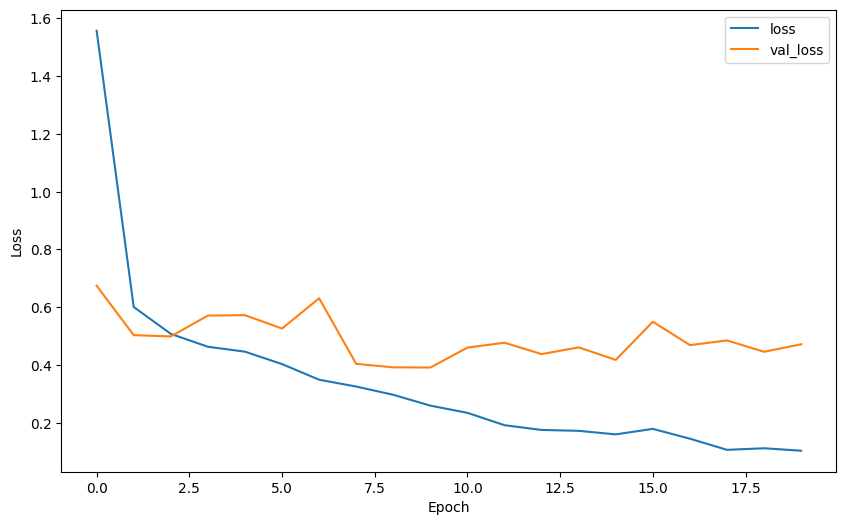

In [73]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

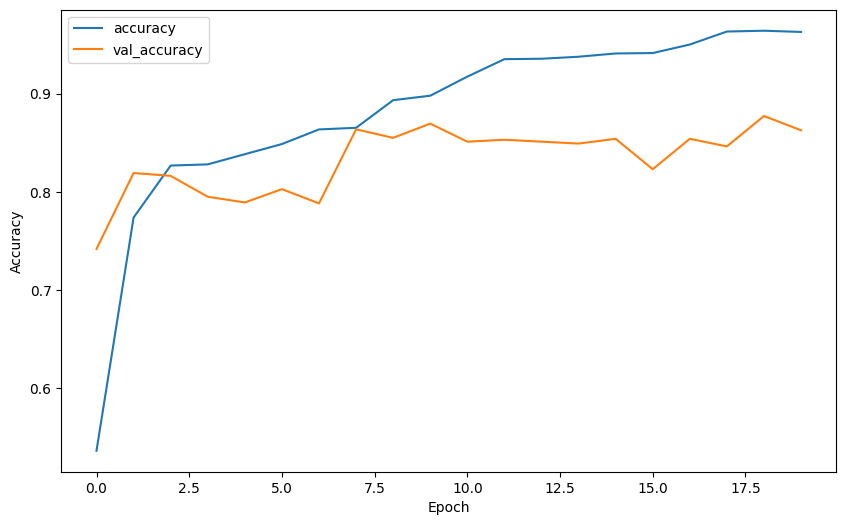

In [74]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [75]:
mobilenet_model.evaluate(training_data)

76/76 ━━━━━━━━━━━━━━━━━━━━ 41s 535ms/step - accuracy: 0.9754 - loss: 0.0773


W0000 00:00:1712783913.392189      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.0686342790722847, 0.9789081811904907]

In [76]:
mobilenet_model.evaluate(validation_data)

33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 505ms/step - accuracy: 0.8787 - loss: 0.4298


[0.4846816658973694, 0.8646034598350525]

In [77]:
pred_probabilities = mobilenet_model.predict(validation_data)
pred_probabilities

 1/33 ━━━━━━━━━━━━━━━━━━━━ 2:05 4s/step

W0000 00:00:1712783938.734943      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 575ms/step


W0000 00:00:1712783957.118392      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([[9.99808192e-01, 1.19900269e-05, 1.58734219e-05, 6.56516131e-05,
        9.81528137e-05],
       [9.98772204e-01, 5.73738816e-06, 1.05228455e-05, 2.27656401e-05,
        1.18884631e-03],
       [8.75592828e-01, 8.82425383e-02, 1.68848899e-03, 3.13284360e-02,
        3.14767007e-03],
       ...,
       [1.72099902e-03, 3.45762703e-03, 3.98884088e-01, 2.65102572e-04,
        5.95672190e-01],
       [3.81633436e-05, 5.65998107e-06, 3.69927147e-03, 1.63901677e-05,
        9.96240497e-01],
       [2.31693302e-05, 1.98905818e-05, 9.72558856e-01, 1.75212394e-04,
        2.72229761e-02]], dtype=float32)

In [78]:
validation_data.classes[:1000]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [79]:
predictions = pred_probabilities > 0.5

In [80]:
validation_data.classes

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [81]:
#print(classification_report(validation_data.classes,predictions))

# **ResNet152**

In [82]:
resnet_model152 = Sequential()

pretrained_model= tf.keras.applications.ResNet152(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model152.add(pretrained_model)
resnet_model152.add(Flatten())
resnet_model152.add(Dense(512, activation='relu'))
resnet_model152.add(Dense(5, activation='softmax'))
resnet_model152.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

resnet_model152.summary()

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ ?                      │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,370,944 (222.67 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,370,944 (222.67 MB)

In [83]:
results = resnet_model152.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks=[early_stop])

Epoch 1/25


W0000 00:00:1712784013.045563      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 9/76 ━━━━━━━━━━━━━━━━━━━━ 2:02 2s/step - accuracy: 0.0560 - loss: 3.1279  

W0000 00:00:1712784027.787077      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.1622 - loss: 2.7118

W0000 00:00:1712784071.136121      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.1624 - loss: 2.7069 - val_accuracy: 0.2785 - val_loss: 1.7241
Epoch 2/25


W0000 00:00:1712784094.619368      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 58s 721ms/step - accuracy: 0.1841 - loss: 1.8775 - val_accuracy: 0.2969 - val_loss: 1.7133
Epoch 3/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 58s 720ms/step - accuracy: 0.1794 - loss: 1.7971 - val_accuracy: 0.1770 - val_loss: 1.7354
Epoch 4/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 59s 722ms/step - accuracy: 0.2766 - loss: 1.6941 - val_accuracy: 0.2776 - val_loss: 1.6211
Epoch 5/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 58s 719ms/step - accuracy: 0.3171 - loss: 1.6276 - val_accuracy: 0.3443 - val_loss: 1.5296
Epoch 6/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 58s 717ms/step - accuracy: 0.2420 - loss: 1.6083 - val_accuracy: 0.2901 - val_loss: 1.5835
Epoch 7/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 58s 716ms/step - accuracy: 0.2382 - loss: 1.6101 - val_accuracy: 0.2930 - val_loss: 1.5567
Epoch 8/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 58s 717ms/step - accuracy: 0.2674 - loss: 1.5879 - val_accuracy: 0.3472 - val_loss: 1.5426
Epoch 9/25
76/76 ━━━━━━━━━━━━━━━━━━━━ 83s 727ms/step - accuracy: 0.2402 - loss: 1.6289 - val_accuracy: 0.313

In [84]:
summary = pd.DataFrame(resnet_model152.history.history)
summary.head()

,accuracy,loss,val_accuracy,val_loss
0,0.181141,2.340189,0.278530,1.724077
1,0.222911,1.870561,0.296905,1.713310
2,0.219603,1.714126,0.176983,1.735413
3,0.253515,1.629821,0.277563,1.621107
4,0.238627,1.653017,0.344294,1.529577


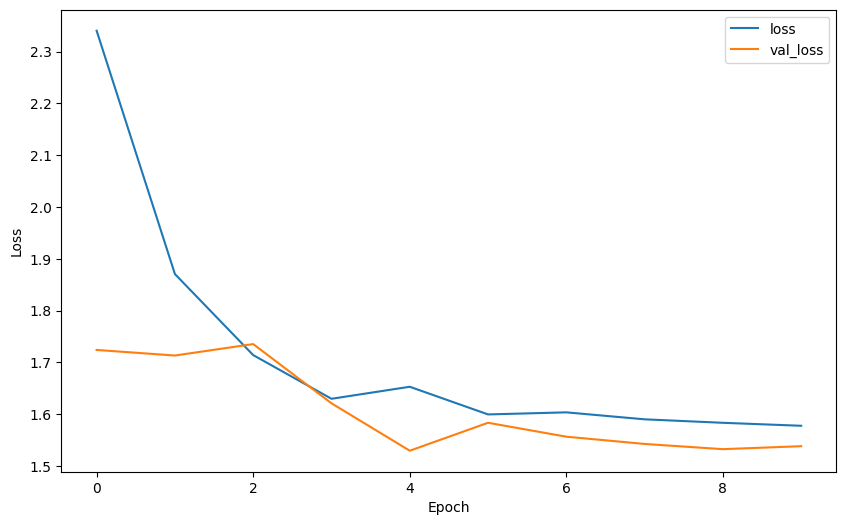

In [85]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

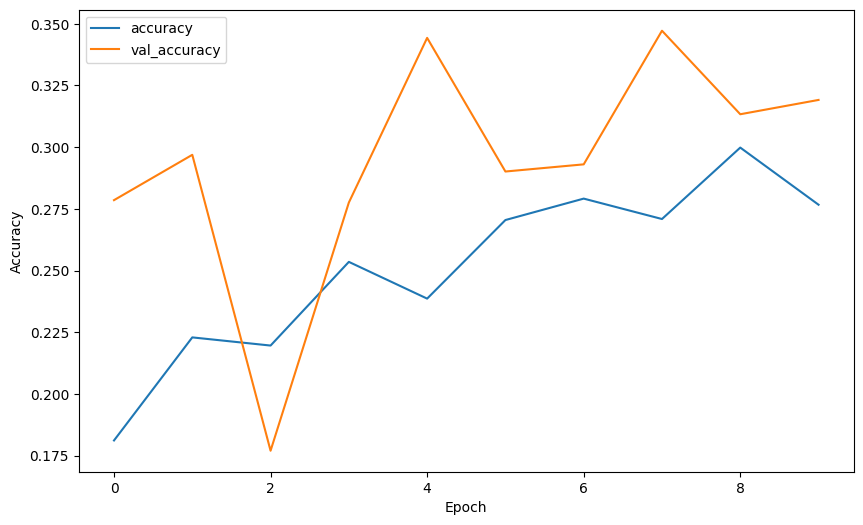

In [86]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [87]:
resnet_model152.evaluate(training_data)
resnet_model152.evaluate(validation_data)

76/76 ━━━━━━━━━━━━━━━━━━━━ 44s 581ms/step - accuracy: 0.4124 - loss: 1.5446


W0000 00:00:1712784697.013705      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 509ms/step - accuracy: 0.4180 - loss: 1.5304


[1.5376920700073242, 0.3133462369441986]

In [88]:
pred_probabilities = resnet_model152.predict(validation_data)
pred_probabilities

 1/33 ━━━━━━━━━━━━━━━━━━━━ 5:38 11s/step

W0000 00:00:1712784727.859936      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 790ms/step


W0000 00:00:1712784753.141988      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([[0.10195169, 0.38105184, 0.1686497 , 0.1644448 , 0.18390195],
       [0.12305373, 0.33037743, 0.182804  , 0.174882  , 0.18888292],
       [0.22914287, 0.1541432 , 0.22010446, 0.18261774, 0.21399172],
       ...,
       [0.11356767, 0.35347375, 0.17693132, 0.16997589, 0.18605138],
       [0.1766737 , 0.21400529, 0.20387469, 0.18915427, 0.21629213],
       [0.1762441 , 0.22279438, 0.20681961, 0.18654263, 0.20759927]],
      dtype=float32)

In [89]:
validation_data.classes[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [90]:
predictions = pred_probabilities > 0.5

In [91]:
validation_data.classes

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [92]:
#print(classification_report(validation_data.classes,predictions))